# Bibliotecas

In [3]:
# from kaggle.api.kaggle_api_extended import KaggleApi
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql import SparkSession
from pyspark.sql import Row
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore", UserWarning)

Sessão Spark (Não necessário para rodar no Databricks)

In [4]:
spark = SparkSession.builder \
    .appName("series_temporais") \
    .config("spark.python.worker.reuse", "false") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .config("spark.network.timeout", "600s") \
    .config("spark.python.worker.timeout", "600") \
    .getOrCreate()

In [5]:
# Datasets Kaggle (Rodar só uma vez)

# api = KaggleApi()
# api.authenticate()

# api.competition_download_files('demand-forecasting-kernels-only', path='datasets')

# Entrada de Dados

In [6]:
df = spark.read.csv('datasets/train.csv', header=True)

df.show()

+----------+-----+----+-----+
|      date|store|item|sales|
+----------+-----+----+-----+
|2013-01-01|    1|   1|   13|
|2013-01-02|    1|   1|   11|
|2013-01-03|    1|   1|   14|
|2013-01-04|    1|   1|   13|
|2013-01-05|    1|   1|   10|
|2013-01-06|    1|   1|   12|
|2013-01-07|    1|   1|   10|
|2013-01-08|    1|   1|    9|
|2013-01-09|    1|   1|   12|
|2013-01-10|    1|   1|    9|
|2013-01-11|    1|   1|    9|
|2013-01-12|    1|   1|    7|
|2013-01-13|    1|   1|   10|
|2013-01-14|    1|   1|   12|
|2013-01-15|    1|   1|    5|
|2013-01-16|    1|   1|    7|
|2013-01-17|    1|   1|   16|
|2013-01-18|    1|   1|    7|
|2013-01-19|    1|   1|   18|
|2013-01-20|    1|   1|   15|
+----------+-----+----+-----+
only showing top 20 rows



# Fundamentos de Média Móvel

## Média Móvel Simples

In [7]:
window3 = Window.orderBy('date').rowsBetween(-2,0)
window7 = Window.orderBy('date').rowsBetween(-6,0)
window30 = Window.orderBy('date').rowsBetween(-29,0)
window119 = Window.orderBy('date').rowsBetween(-119,0)
window360 = Window.orderBy('date').rowsBetween(-359,0)


df_with_sma = (
    df
    .filter((F.col('item') == 1) & (F.col('store')== 1))
    .withColumn('SMA_3', F.avg(F.col('sales')).over(window3))
    .withColumn('SMA_7', F.avg(F.col('sales')).over(window7))
    .withColumn('SMA_30', F.avg(F.col('sales')).over(window30))
    .withColumn('SMA_120', F.avg(F.col('sales')).over(window119))
    .withColumn('SMA_360', F.avg(F.col('sales')).over(window360))
)

df_with_sma.show()

+----------+-----+----+-----+------------------+------------------+------------------+------------------+------------------+
|      date|store|item|sales|             SMA_3|             SMA_7|            SMA_30|           SMA_120|           SMA_360|
+----------+-----+----+-----+------------------+------------------+------------------+------------------+------------------+
|2013-01-01|    1|   1|   13|              13.0|              13.0|              13.0|              13.0|              13.0|
|2013-01-02|    1|   1|   11|              12.0|              12.0|              12.0|              12.0|              12.0|
|2013-01-03|    1|   1|   14|12.666666666666666|12.666666666666666|12.666666666666666|12.666666666666666|12.666666666666666|
|2013-01-04|    1|   1|   13|12.666666666666666|             12.75|             12.75|             12.75|             12.75|
|2013-01-05|    1|   1|   10|12.333333333333334|              12.2|              12.2|              12.2|              12.2|


## Plot - SMA

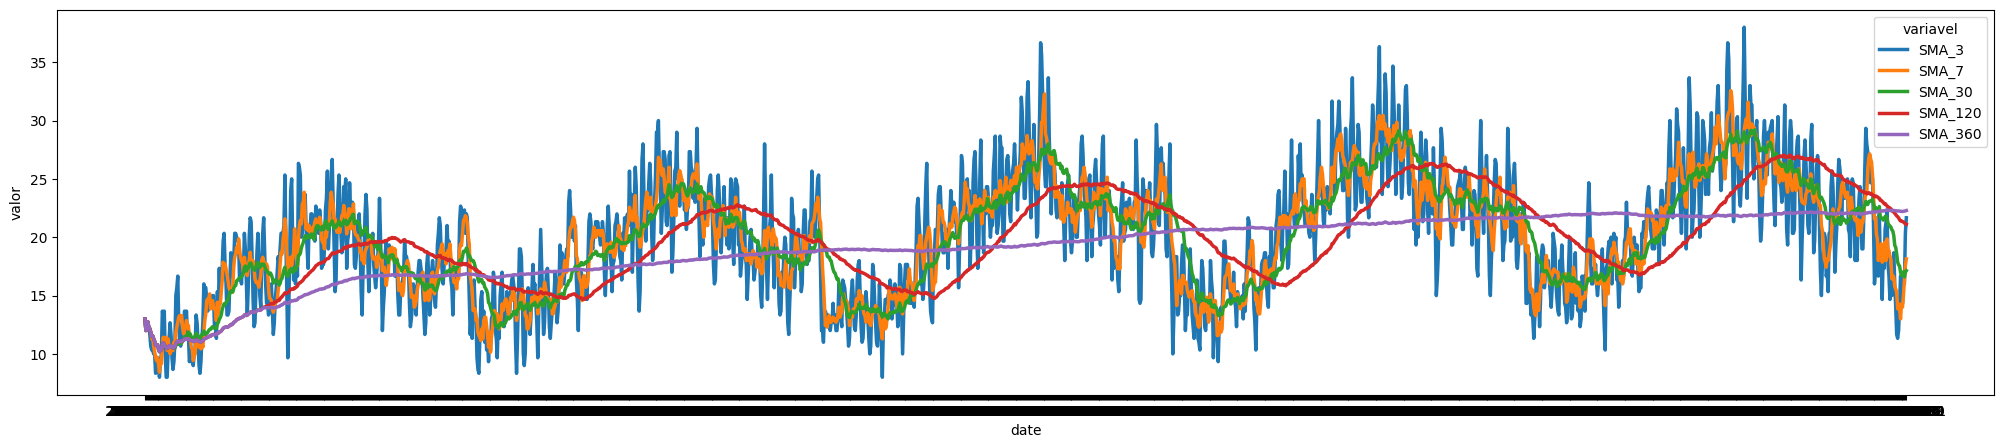

In [8]:
df_plot = df_with_sma.toPandas()

plt.figure(figsize=(25, 5))

plot = df_plot.melt(id_vars='date', value_vars=['SMA_3', 'SMA_7', 'SMA_30', 'SMA_120', 'SMA_360'], var_name='variavel', value_name='valor')

sns.lineplot(data=plot, x='date', y='valor', hue='variavel', linewidth=2.5)

plt.show()

## Média Móvel Exponencial

In [9]:
df_plot['sales'] = pd.to_numeric(df_plot['sales'])

df_plot['EMA_120'] = df_plot['sales'].ewm(span=120, adjust=False).mean()

df_plot

,date,store,item,sales,SMA_3,SMA_7,SMA_30,SMA_120,SMA_360,EMA_120
0,2013-01-01,1,1,13,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
1,2013-01-02,1,1,11,12.000000,12.000000,12.000000,12.000000,12.000000,12.966942
2,2013-01-03,1,1,14,12.666667,12.666667,12.666667,12.666667,12.666667,12.984017
3,2013-01-04,1,1,13,12.666667,12.750000,12.750000,12.750000,12.750000,12.984282
4,2013-01-05,1,1,10,12.333333,12.200000,12.200000,12.200000,12.200000,12.934955
...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,14.333333,14.000000,16.866667,21.341667,22.205556,20.747390
1822,2017-12-28,1,1,19,16.333333,15.000000,17.033333,21.316667,22.216667,20.718507
1823,2017-12-29,1,1,15,16.000000,16.285714,16.600000,21.225000,22.230556,20.623987
1824,2017-12-30,1,1,27,20.333333,17.571429,17.000000,21.133333,22.261111,20.729375


## Plot - EMA

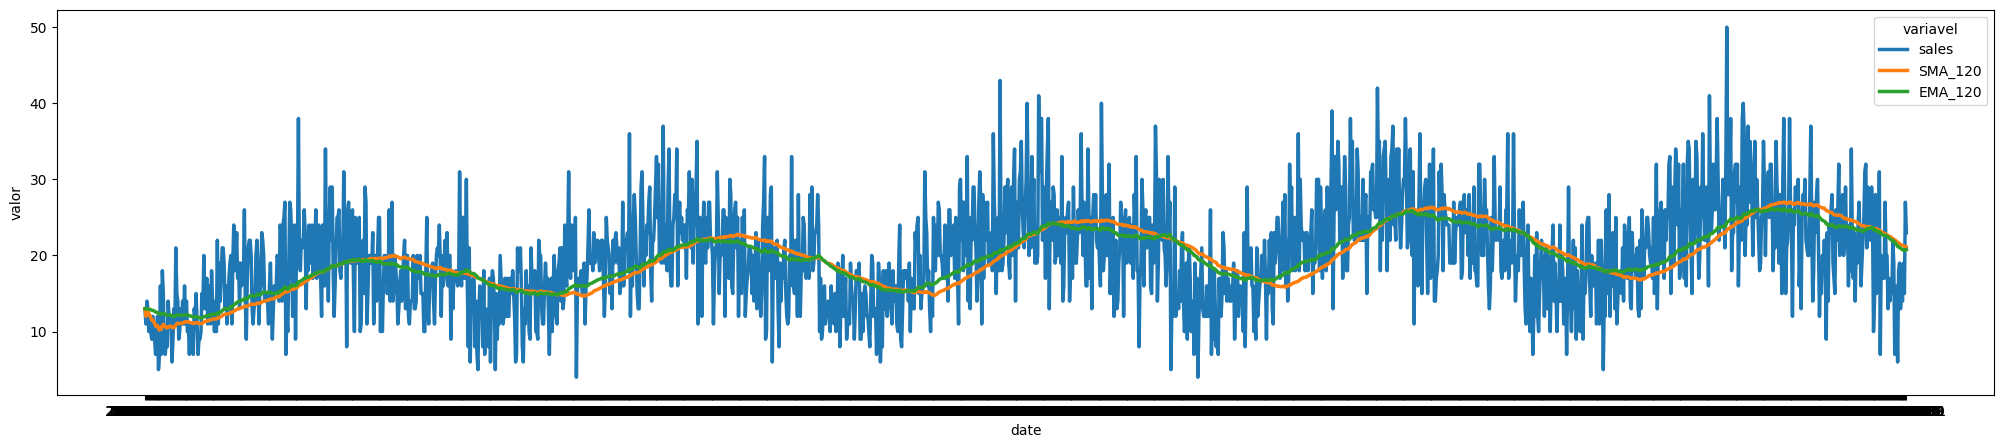

In [10]:
plt.figure(figsize=(25, 5))

plot = df_plot.melt(id_vars='date', value_vars=['sales','SMA_120', 'EMA_120'], var_name='variavel', value_name='valor')

sns.lineplot(data=plot, x='date', y='valor', hue='variavel', linewidth=2.5)

plt.show()

## Média Móvel Ponderada (WMA)

A WMA vai ser calculada usando peso definido de acordo com a data (quanto mais próximo, mais forte o valor da média) - Peso Linear

In [11]:
df_plot

,date,store,item,sales,SMA_3,SMA_7,SMA_30,SMA_120,SMA_360,EMA_120
0,2013-01-01,1,1,13,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
1,2013-01-02,1,1,11,12.000000,12.000000,12.000000,12.000000,12.000000,12.966942
2,2013-01-03,1,1,14,12.666667,12.666667,12.666667,12.666667,12.666667,12.984017
3,2013-01-04,1,1,13,12.666667,12.750000,12.750000,12.750000,12.750000,12.984282
4,2013-01-05,1,1,10,12.333333,12.200000,12.200000,12.200000,12.200000,12.934955
...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,14.333333,14.000000,16.866667,21.341667,22.205556,20.747390
1822,2017-12-28,1,1,19,16.333333,15.000000,17.033333,21.316667,22.216667,20.718507
1823,2017-12-29,1,1,15,16.000000,16.285714,16.600000,21.225000,22.230556,20.623987
1824,2017-12-30,1,1,27,20.333333,17.571429,17.000000,21.133333,22.261111,20.729375


In [12]:
size = 120

weight = np.arange(1, size+1)

df_plot[f'WMA_{size}'] = df_plot['sales'].rolling(size).apply(lambda x: np.dot(x, weight)/weight.sum(), raw=True)

df_plot

,date,store,item,sales,SMA_3,SMA_7,SMA_30,SMA_120,SMA_360,EMA_120,WMA_120
0,2013-01-01,1,1,13,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,NaN
1,2013-01-02,1,1,11,12.000000,12.000000,12.000000,12.000000,12.000000,12.966942,NaN
2,2013-01-03,1,1,14,12.666667,12.666667,12.666667,12.666667,12.666667,12.984017,NaN
3,2013-01-04,1,1,13,12.666667,12.750000,12.750000,12.750000,12.750000,12.984282,NaN
4,2013-01-05,1,1,10,12.333333,12.200000,12.200000,12.200000,12.200000,12.934955,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,14.333333,14.000000,16.866667,21.341667,22.205556,20.747390,20.031405
1822,2017-12-28,1,1,19,16.333333,15.000000,17.033333,21.316667,22.216667,20.718507,19.992700
1823,2017-12-29,1,1,15,16.000000,16.285714,16.600000,21.225000,22.230556,20.623987,19.888292
1824,2017-12-30,1,1,27,20.333333,17.571429,17.000000,21.133333,22.261111,20.729375,19.983747


## Plot WMA

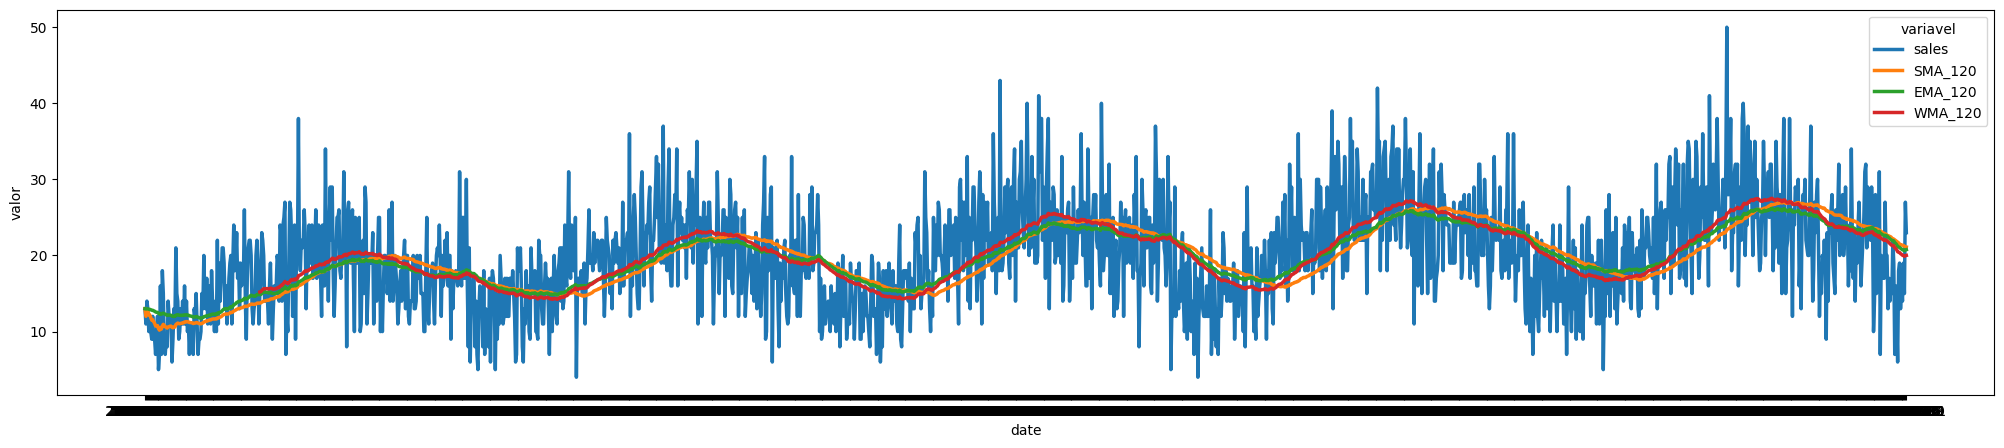

In [13]:
plt.figure(figsize=(25, 5))

plot = df_plot.melt(id_vars='date', value_vars=['sales','SMA_120', 'EMA_120', 'WMA_120'], var_name='variavel', value_name='valor')

sns.lineplot(data=plot, x='date', y='valor', hue='variavel', linewidth=2.5)

plt.show()

# Projeções com Baseline

## Baseline Constante

In [14]:


min_date = pd.to_datetime(df_plot['date'].max())

days_to_add = 15

df_datas = (
    spark.range(1)
    .selectExpr(f"to_date('{min_date}') as min_date")
    .withColumn("max_date", F.date_add(F.col("min_date"), days_to_add))
    .withColumn(
        "datas",
        F.expr("sequence(min_date, max_date, interval 1 day)")
    )
)

df_datas = df_datas.select(F.explode("datas").alias("data"))

# df_datas.show()



In [16]:
df_baseline = (
    df_with_sma
    .drop('SMA_3', 'SMA_30', 'SMA_120', 'SMA_360')
    .sort(F.desc(F.col('date')))
)

window7 = Window.orderBy('date').rowsBetween(-6,0)

# A data tem que ser um ponto fixo antes da iteração
max_date = df_baseline.select(F.max('date')).collect()[0][0]
max_date = datetime.strptime(str(max_date), "%Y-%m-%d").date()

days_to_add = 15

for i in range(days_to_add):

    df_baseline.persist()
    # df_baseline = df_baseline.cache()

    new_date = max_date + timedelta(days=i+1)

    max_sma7 = df_baseline.select(F.round(F.col('SMA_7'), 2)).limit(1).collect()[0][0]   

    newrow = spark.createDataFrame([{
        'date':     new_date,
        'store':    1,
        'item':     1,
        'sales':    float(max_sma7)
    }])

    df_baseline = (
        df_baseline
        .drop('SMA_7')
        .unionByName(newrow)
        .withColumn('SMA_7', F.round(F.avg(F.col('sales')).over(window7), 2))
        .sort(F.desc(F.col('date')))
    )


df_baseline.sort(F.desc('date')).show()


Py4JJavaError: An error occurred while calling o243.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 28.0 failed 1 times, most recent failure: Lost task 1.0 in stage 28.0 (TID 21) (DESKTOP-61IQVID executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 37 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.UnionRDD.compute(UnionRDD.scala:106)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:713)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:757)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 37 more


## MAE - Erro Médio Absoluto e RMSE - Root Mean Square Error

Calculando o erro médio absoluto e RMSE nos dados de previsão

In [ ]:
df_baseline_with_error = (
    df_baseline
    .filter(F.col('date') >= '2018-01-01')
    .withColumn("erro_absoluto", F.abs(F.col('sales') - F.col('SMA_7')))
    .withColumn("erro_quadratico", F.pow(F.col('sales') - F.col('SMA_7'), 2))
)

df_baseline_with_error.show()

+----------+-----+----+-----+-----+--------------------+--------------------+
|      date|store|item|sales|SMA_7|       erro_absoluto|     erro_quadratico|
+----------+-----+----+-----+-----+--------------------+--------------------+
|2018-01-15|    1|   1|19.98|20.02| 0.03999999999999915|0.001599999999999...|
|2018-01-14|    1|   1|19.99|19.98| 0.00999999999999801|9.999999999996021E-5|
|2018-01-13|    1|   1|20.11|19.99|   0.120000000000001|0.014400000000000239|
|2018-01-12|    1|   1|20.12|20.11|0.010000000000001563|1.000000000000312...|
|2018-01-11|    1|   1|20.11|20.12|0.010000000000001563|1.000000000000312...|
|2018-01-10|    1|   1| 20.0|20.11| 0.10999999999999943|0.012099999999999875|
|2018-01-09|    1|   1|19.86| 20.0| 0.14000000000000057| 0.01960000000000016|
|2018-01-08|    1|   1|19.65|19.86| 0.21000000000000085| 0.04410000000000036|
|2018-01-07|    1|   1|20.07|19.65|  0.4200000000000017| 0.17640000000000144|
|2018-01-06|    1|   1|20.93|20.07|  0.8599999999999994|   0.739

In [ ]:
rmse = df_baseline_with_error.select(F.sqrt(F.mean("erro_quadratico")).alias("RMSE")).collect()[0]["RMSE"]
mae = df_baseline_with_error.select(F.mean("erro_absoluto").alias("MAE")).collect()[0]["MAE"]


print(f"Erro Médio Absoluto (MAE): {mae:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")


Erro Médio Absoluto (MAE): 0.31
Raiz do Erro Quadrático Médio (RMSE): 0.44
